### Import librairies

In [1]:
import pandas as pd
import numpy as np
import nltk
import ssl
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

#pre-processing
import re, string
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


import seaborn as sns

### Import data

In [2]:
data = pd.read_csv("data_review.csv")

In [3]:
data.head()

,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID;;;;;;;;;;;;;;;;;;
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26;;;;;;;;;;;;;;;1;;;
1,;;;;;;;;;;;;;;;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,;;;;;;;;;;;;;;;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,;;;;;;;;;;;;;;;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,;;;;;;;;;;;;;;;;;;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data exploration

In [41]:
data.describe()

,Trip ID
count,32096.000000
mean,28803.110699
std,13047.589849
min,1.000000
25%,18168.750000
50%,28094.500000
75%,39931.250000
max,52653.000000


In [5]:
nb_empty_comment = data["Comment"].isna().sum()

In [8]:
number_of_valid_comment = data.shape[0] - nb_empty_comment
number_of_valid_comment

4829

In [7]:
data['Rate'].unique()

array(['1', nan, '3', '0', '4', '5', '2', '2021-08-28T12:21:39.869Z'],
      dtype=object)

In [8]:
data[data['Rate'].str.contains("2021-08-28T12:21:39.869Z")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

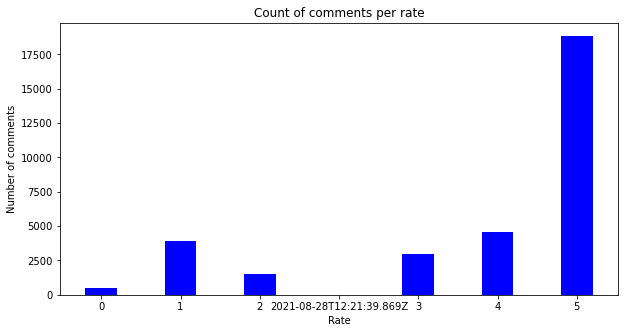

In [11]:
group_by_rate = data.groupby(["Rate"]).size()
dict_rate = group_by_rate.to_dict()

courses = list(dict_rate.keys())
values = list(dict_rate.values())
  
fig = plt.figure(figsize = (10, 5))

plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Rate")
plt.ylabel("Number of comments")
plt.title("Count of comments per rate")
plt.show()

### Remove samples with nan values in comment column

In [12]:
processed_df = data[data['Comment'].notna()]

In [13]:
processed_df.shape

(4829, 9)

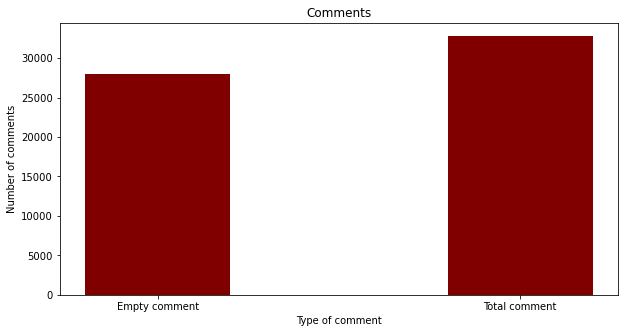

In [14]:
data_bar = {'Empty comment': nb_empty_comment, 'Total comment':data.shape[0]}
courses = list(data_bar.keys())
values = list(data_bar.values())
  
fig = plt.figure(figsize = (10, 5))

plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Type of comment")
plt.ylabel("Number of comments")
plt.title("Comments")
plt.show()

In [15]:
processed_df.to_csv("csv_without_null_comments.csv", index=False)

In [16]:
test_csv = pd.read_csv("csv_without_null_comments.csv")
test_csv.shape

(4829, 9)

In [24]:
test_csv.head()

,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID;;;;;;;;;;;;;;;;;;
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26;;;;;;;;;;;;;;;1;;;
1,19487,79fa4190-76bd-4b48-a6aa-c22b1f5f9355,NaN,Pas de frein arrière,3,2021-09-26T14:01:24.832Z,2021-09-26T14:01:24.832Z,608156dcdeb7eb746a8b7ba0,61507aff10168f3d483c51c9;;;;;;;;;;;;;;;21;;;
2,31714,7ff43434-065d-4a08-83b2-9a6077c9d0a3,49934.0,Ct génial,0,2022-02-21T16:43:55.149001Z,2022-02-21T16:43:55.149001Z,NaN,;;;;;;;;;;;;;;;;;;
3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;;
4,32873,1d83eae9-2658-4cee-9afe-6f4824d3ec47,51909.0,Vélo très bien mais « vélo rue » du Borrigo av...,3,2022-03-09T09:26:07.593932Z,2022-03-09T09:26:07.593932Z,NaN,;;;;;;;;;;;;;;;;;;


## Comment processing and text exploration

### Download ntlk stopwords

In [14]:
DOWNLOAD_NLTK_DATA = False

if DOWNLOAD_NLTK_DATA:

    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    nltk.download()

### Set ntlk data path

In [15]:
nltk_data_path = "/Users/fsz/Desktop/projet_nlp/nltk_data/"
nltk.data.path.append(nltk_data_path)

In [16]:
print(stopwords.words('french'))

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

In [17]:
def generate_wordcloud(remove_stop_words=True):
    comment_words = ''
    
    if remove_stop_words:
        stopwords_to_remove = stopwords.words('french')
    
    else:
        stopwords_to_remove = set("")
    
    for val in processed_df.Comment:

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
        background_color ='white',
        stopwords = stopwords_to_remove,
        min_font_size = 10).generate(comment_words)
    
    return wordcloud

In [18]:
def plot_wordcloud(wordcloud):
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

## Wordcloud with stopwords

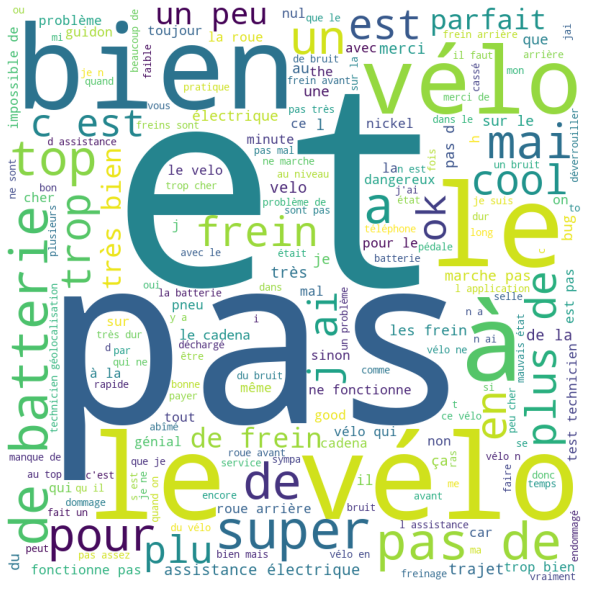

In [19]:
wordcloud_with_stopwords = generate_wordcloud(remove_stop_words=False)
plot_wordcloud(wordcloud_with_stopwords)

## Wordcloud with stopwords 

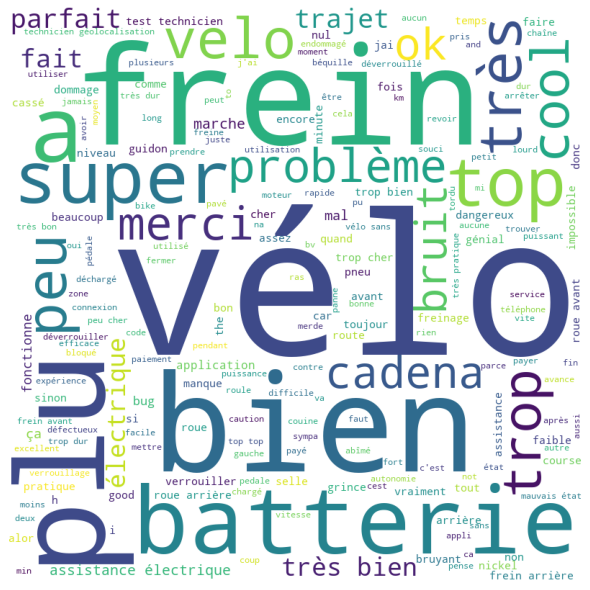

In [20]:
wordcloud_without_stopwords = generate_wordcloud()
plot_wordcloud(wordcloud_without_stopwords)

#### Import du CSV sans les lignes nulles

In [10]:
aaaa=pd.read_csv("csv_without_null_comments2.csv")
aaaa.rename(columns={'Classe;;;;;;;;;;;;;;;;;':'Classe'}, inplace=True)
aaaa['Classe'] = aaaa["Classe"].str.replace(";","")
aaaa.head()

,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1.0,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26,Technique
1,19487,79fa4190-76bd-4b48-a6aa-c22b1f5f9355,NaN,Pas de frein arrière,3.0,2021-09-26T14:01:24.832Z,2021-09-26T14:01:24.832Z,608156dcdeb7eb746a8b7ba0,61507aff10168f3d483c51c9,Technique
2,31714,7ff43434-065d-4a08-83b2-9a6077c9d0a3,49934.0,Ct génial,0.0,2022-02-21T16:43:55.149001Z,2022-02-21T16:43:55.149001Z,NaN,NaN,Pas technique
3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0.0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;,NaN
4,32873,1d83eae9-2658-4cee-9afe-6f4824d3ec47,51909.0,Vélo très bien mais « vélo rue » du Borrigo av...,3.0,2022-03-09T09:26:07.593932Z,2022-03-09T09:26:07.593932Z,NaN,NaN,Pas technique


In [4]:
aaaa.shape

(4829, 10)

##### Liste Com2 qui récupère les commentaires

In [11]:
Com2 = aaaa["Comment"].tolist()
print('Le nombre de commentaires est :',len(Com2))

Le nombre de commentaires est : 4829


In [6]:
aaaa.dtypes

ID              object
UUID            object
Trip ID        float64
Comment         object
Rate           float64
Created At      object
Updated At      object
User Old ID     object
Trip Old ID     object
Classe          object
dtype: object

In [12]:
aaaa['Comms'] = Com2
aaaa.head()

,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe,Comms
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1.0,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26,Technique,Sans assistance électrique
1,19487,79fa4190-76bd-4b48-a6aa-c22b1f5f9355,NaN,Pas de frein arrière,3.0,2021-09-26T14:01:24.832Z,2021-09-26T14:01:24.832Z,608156dcdeb7eb746a8b7ba0,61507aff10168f3d483c51c9,Technique,Pas de frein arrière
2,31714,7ff43434-065d-4a08-83b2-9a6077c9d0a3,49934.0,Ct génial,0.0,2022-02-21T16:43:55.149001Z,2022-02-21T16:43:55.149001Z,NaN,NaN,Pas technique,Ct génial
3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0.0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;,NaN,Marche pas
4,32873,1d83eae9-2658-4cee-9afe-6f4824d3ec47,51909.0,Vélo très bien mais « vélo rue » du Borrigo av...,3.0,2022-03-09T09:26:07.593932Z,2022-03-09T09:26:07.593932Z,NaN,NaN,Pas technique,Vélo très bien mais « vélo rue » du Borrigo av...


#### Colonne pour le nombre de caractères par commentaire + moyenne du nombre de caractères + note moyenne

In [13]:
aaaa['Length'] = aaaa['Comment'].apply(lambda x: len(str(x)))
#aaaa.drop(aaaa[aaaa['Length'] <= 2].index, inplace=True)
print("Mean rate :",aaaa["Rate"].mean())
print("Mean comments length :",aaaa["Length"].mean())
aaaa.head()

Mean rate : 3.247151439817692
Mean comments length : 23.732449782563677


,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe,Comms,Length
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1.0,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26,Technique,Sans assistance électrique,27
1,19487,79fa4190-76bd-4b48-a6aa-c22b1f5f9355,NaN,Pas de frein arrière,3.0,2021-09-26T14:01:24.832Z,2021-09-26T14:01:24.832Z,608156dcdeb7eb746a8b7ba0,61507aff10168f3d483c51c9,Technique,Pas de frein arrière,21
2,31714,7ff43434-065d-4a08-83b2-9a6077c9d0a3,49934.0,Ct génial,0.0,2022-02-21T16:43:55.149001Z,2022-02-21T16:43:55.149001Z,NaN,NaN,Pas technique,Ct génial,9
3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0.0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;,NaN,Marche pas,11
4,32873,1d83eae9-2658-4cee-9afe-6f4824d3ec47,51909.0,Vélo très bien mais « vélo rue » du Borrigo av...,3.0,2022-03-09T09:26:07.593932Z,2022-03-09T09:26:07.593932Z,NaN,NaN,Pas technique,Vélo très bien mais « vélo rue » du Borrigo av...,83


#### Normalisation de la colonne Comms en enlevant les caractères spéciaux + mise en minuscules

In [14]:
aaaa.drop(aaaa[aaaa.Length < 2].index, inplace=True)

In [15]:
#aaaa["Comment"] = aaaa['Comment'].str.normalize('NFKD').str.encode('ASCII', errors='ignore').str.decode('utf-8')
aaaa["Comms"] = aaaa['Comms'].str.normalize('NFKD').str.encode('ASCII', errors='ignore').str.decode('utf-8')
aaaa.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

aaaa["Comms"] = aaaa['Comms'].str.lower()
aaaa.head(2)

,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe,Comms,Length
0,19469,5f090183-575f-4b68-bfd8-8ca64e271f60,NaN,Sans assistance électrique,1.0,2021-09-26T11:30:17.535Z,2021-09-26T11:30:17.535Z,60d193e09485da0e5c6c5c51,6150591710168f3d48342d26,Technique,sans assistance electrique,27
1,19487,79fa4190-76bd-4b48-a6aa-c22b1f5f9355,NaN,Pas de frein arrière,3.0,2021-09-26T14:01:24.832Z,2021-09-26T14:01:24.832Z,608156dcdeb7eb746a8b7ba0,61507aff10168f3d483c51c9,Technique,pas de frein arriere,21


### depuis site 

In [18]:
def preprocess(Comms):
    Comms = Comms.lower() 
    Comms = Comms.strip()  
    Comms = re.compile('<.*?>').sub('', Comms) 
    Comms = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', Comms)  
    Comms = re.sub('\s+', ' ', Comms)  
    Comms = re.sub(r'\[[0-9]*\]',' ', Comms) 
    Comms = re.sub(r'[^\w\s]', '', str(Comms).lower().strip())
    Comms = re.sub(r'\d',' ', Comms) 
    Comms = re.sub(r'\s+',' ', Comms) 
    return Comms


### depuis site 

In [11]:
import nltk
nltk.download('stopwords')
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('french')]
    return ' '.join(a)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### depuis site 

In [12]:
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

### depuis site 

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
              
def finalpreprocess(string):
    return lemmatizer((preprocess(string)))

aaaa['Comms'] = aaaa['Comms'].apply(lambda x: finalpreprocess(x))
aaaa.head(3)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


AttributeError: 'float' object has no attribute 'lower'

In [16]:
aaaa['Comms'] = aaaa['Comms'].astype(str)
aaaa.dtypes

ID              object
UUID            object
Trip ID        float64
Comment         object
Rate           float64
Created At      object
Updated At      object
User Old ID     object
Trip Old ID     object
Classe          object
Comms           object
Length           int64
dtype: object

In [17]:
import nltk
aaaa["Tokens"] = aaaa.apply(lambda row: nltk.word_tokenize(row["Comms"]), axis=1)
print(aaaa['Tokens'])

0                          [sans, assistance, electrique]
1                               [pas, de, frein, arriere]
2                                            [ct, genial]
3                                           [marche, pas]
4       [velo, tres, bien, mais, velo, rue, du, borrig...
                              ...                        
4823    [great, service, ., le, velo, tremble, et, les...
4824                                                 [nn]
4825             [lumiere, avant, dirigee, trop, haut, .]
4826    [problemes, rencontres, avec, la, batterie, .,...
4827                                [velo, pas, recharge]
Name: Tokens, Length: 4589, dtype: object


In [15]:
aaaa.to_csv('csv_normalized_tokenized.csv')

### -------- MACHINE LEARNING --------

In [23]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

#X = vectorizer.fit_transform(X.ravel()).toarray()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('csv_normalized_tokenized.csv')

df = df[df['Classe'].notna()]
df.head(10)
df.shape

(472, 14)

In [24]:
X = df['Tokens']
y = df['Classe']

vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(X.ravel()).toarray()

#tfidfconverter = TfidfTransformer() 
#X = tfidfconverter.fit_transform(X).toarray()

# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Instantiate rf
rf = RandomForestClassifier(n_estimators=25, random_state=1)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=1)

In [26]:
y_pred = rf.predict(X_test)
print(X_test)
print(y_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['Technique' 'Pas technique' 'Pas technique' 'Technique' 'Pas technique'
 'Technique' 'Technique' 'Pas technique' 'Pas technique' 'Technique'
 'Technique' 'Technique' 'Technique' 'Technique' 'Technique'
 'Pas technique' 'Pas technique' 'Technique' 'Pas technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Pas technique'
 'Technique' 'Technique' 'Pas technique' 'Technique' 'Technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Pas technique'
 'Technique' 'Pas technique' 'Pas technique' 'Pas technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Technique' 'Technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Pas technique'
 'Pas technique' 'Pas technique' 'Technique' 'Technique' 'Pas technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Technique' 'Technique'
 'Pas technique' 'Pas technique' 'Pas technique' 'Technique'
 'Pas technique

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion matrix is : \n", confusion_matrix(y_test, y_pred))
print("Accuracy score is :", accuracy_score(y_test, y_pred))

Confusion matrix is : 
 [[54  2]
 [ 8 31]]
Accuracy score is : 0.8947368421052632


In [32]:
vtest = ["le velo a un probleme de batterie","super trajet", "la course est chere", "la batterie marche pas", 
     "bonjour", "velo casse","freins bloques","banane"]

vtest = vectorizer.transform(vtest).toarray()
rf.predict(vtest)

array(['Technique', 'Pas technique', 'Pas technique', 'Technique',
       'Pas technique', 'Technique', 'Technique', 'Pas technique'],
      dtype=object)

In [33]:
print(type(y_test))
y_test.unique()

<class 'pandas.core.series.Series'>


array(['Technique', 'Pas technique'], dtype=object)

In [34]:
classifiers = [RandomForestClassifier(n_estimators=25, random_state=1)]


Nouveau dataframe pour prédire sur l'ensemble des data non annotées

Drop des 487 premières lignes annotées

Nouveau csv sans les lignes annotées
   

In [17]:
df4 = pd.read_csv('csv_not_annoted.csv')
df4.head()

,Unnamed: 0,Unnamed: 0.1,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe,Comms,Length,comms_test,Tokens
0,3,3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0.0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;,NaN,marche pas,11,marche pas,"['marche', 'pas']"
1,8,8,19537,5cdeb8ac-7b75-45e1-b607-7a2e7bef7569,NaN,il marche pas non plus,5.0,2021-09-26T22:26:38.462Z,2021-09-26T22:26:38.462Z,60f5e974dcb3f875960b1da2,6150f30f10168f3d485c0605;;;;;;;;;;;;;;;;;,NaN,il marche pas non plus,22,il marche pas non plus,"['il', 'marche', 'pas', 'non', 'plus']"
2,153,153,1103,90b6736f-dc7f-459f-adac-cff6bcea1097,12784.0,Fonctionne pas,1.0,2021-03-29T16:49:57.815Z,2021-03-29T16:49:57.815Z,60617db1375f37201a26d26c,60620029375f37201a30ec53;;;;;;;;;;;;;;;;;,NaN,fonctionne pas,15,fonctionne pas,"['fonctionne', 'pas']"
3,173,173,24030,638b3d3a-f083-4417-a2ec-70cebd195f5a,38460.0,Il marche mas,1.0,2021-10-28T17:08:23.367929Z,2021-10-28T17:08:23.367929Z,NaN,;;;;;;;;;;;;;;;;;,NaN,il marche mas,13,il marche mas,"['il', 'marche', 'mas']"
4,248,248,1691,626f5dd8-b7c7-424c-8f2b-e287c5cb3693,10432.0,Marche pas,1.0,2021-04-18T10:15:27.655Z,2021-04-18T10:15:27.655Z,601980a4cdf79f14f6e5413c,607c0626a6e1cf2c3c66bcd2;;;;;;;;;;;;;;;;;,NaN,marche pas,10,marche pas,"['marche', 'pas']"


In [18]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X = vectorizer.fit_transform(X.ravel()).toarray()

NameError: name 'X' is not defined

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split

# Load data
dfb = pd.read_csv('csv_not_annoted.csv')
dfb = dfb[dfb['Comment'].notna()]
dfb.head(10)

,Unnamed: 0,Unnamed: 0.1,ID,UUID,Trip ID,Comment,Rate,Created At,Updated At,User Old ID,Trip Old ID,Classe,Comms,Length,comms_test,Tokens
0,3,3,31956,737320b2-0e91-42fa-9f48-3e651b453e02,50342.0,Marche pas,0.0,2022-02-25T12:28:03.504405Z,2022-02-25T12:28:03.504405Z,NaN,;;;;;;;;;;;;;;;;;,NaN,marche pas,11,marche pas,"['marche', 'pas']"
1,8,8,19537,5cdeb8ac-7b75-45e1-b607-7a2e7bef7569,NaN,il marche pas non plus,5.0,2021-09-26T22:26:38.462Z,2021-09-26T22:26:38.462Z,60f5e974dcb3f875960b1da2,6150f30f10168f3d485c0605;;;;;;;;;;;;;;;;;,NaN,il marche pas non plus,22,il marche pas non plus,"['il', 'marche', 'pas', 'non', 'plus']"
2,153,153,1103,90b6736f-dc7f-459f-adac-cff6bcea1097,12784.0,Fonctionne pas,1.0,2021-03-29T16:49:57.815Z,2021-03-29T16:49:57.815Z,60617db1375f37201a26d26c,60620029375f37201a30ec53;;;;;;;;;;;;;;;;;,NaN,fonctionne pas,15,fonctionne pas,"['fonctionne', 'pas']"
3,173,173,24030,638b3d3a-f083-4417-a2ec-70cebd195f5a,38460.0,Il marche mas,1.0,2021-10-28T17:08:23.367929Z,2021-10-28T17:08:23.367929Z,NaN,;;;;;;;;;;;;;;;;;,NaN,il marche mas,13,il marche mas,"['il', 'marche', 'mas']"
4,248,248,1691,626f5dd8-b7c7-424c-8f2b-e287c5cb3693,10432.0,Marche pas,1.0,2021-04-18T10:15:27.655Z,2021-04-18T10:15:27.655Z,601980a4cdf79f14f6e5413c,607c0626a6e1cf2c3c66bcd2;;;;;;;;;;;;;;;;;,NaN,marche pas,10,marche pas,"['marche', 'pas']"
5,297,297,24625,ed5f9b9e-c5f7-4313-aa09-c5885971e48f,39238.0,Marche pas,1.0,2021-11-04T20:45:34.266199Z,2021-11-04T20:45:34.266199Z,NaN,;;;;;;;;;;;;;;;;;,NaN,marche pas,11,marche pas,"['marche', 'pas']"
6,298,298,1882,49d861e9-8c4f-42b8-b433-4b98f2af7ef4,10702.0,Ne marche pas,1.0,2021-04-23T10:07:03.833Z,2021-04-23T10:07:03.833Z,6024ffe1e0634807827be4da,60829c05deb7eb746a980480;;;;;;;;;;;;;;;;;,NaN,ne marche pas,14,ne marche pas,"['ne', 'marche', 'pas']"
7,309,309,1922,6ec0178e-656b-4301-b706-ac9316a40206,13491.0,Pastèque le vélo,5.0,2021-04-23T20:04:40.121Z,2021-04-23T20:04:40.121Z,608080cadeb7eb746a849a5c,608322e1deb7eb746aa313d1;;;;;;;;;;;;;;;;;,NaN,pasteque le velo,16,pasteque le velo,"['pasteque', 'le', 'velo']"
8,340,340,28377,0f8f076f-9c8a-4282-ace7-5102948e9d01,44805.0,Ne fonctionne pas,1.0,2022-01-02T23:44:09.897443Z,2022-01-02T23:44:09.897443Z,NaN,;;;;;;;;;;;;;;;;;,NaN,ne fonctionne pas,18,ne fonctionne pas,"['ne', 'fonctionne', 'pas']"
9,357,357,2033,052dbcbd-ca4e-45e4-8346-429aba5aa7cc,12188.0,Ne marche pas,1.0,2021-04-25T13:29:50.807Z,2021-04-25T13:29:50.807Z,604cc21fbc080b11804c0159,60856da6deb7eb746acb5041;;;;;;;;;;;;;;;;;,NaN,ne marche pas,13,ne marche pas,"['ne', 'marche', 'pas']"


In [20]:
dfb.shape

(4341, 16)

In [21]:
Xb = dfb['Tokens']

#vectorizer = CountVectorizer(max_features=1500)
Xb = vectorizer.transform(Xb.ravel()).toarray()

#tfidfconverter = TfidfTransformer() 
#Xb = tfidfconverter.fit_transform(Xb).toarray()


yb_pred = rf.predict(Xb)

NotFittedError: Vocabulary not fitted or provided

In [125]:
print(Xb)
print(yb_pred)

0                                       ['marche', 'pas']
1                  ['il', 'marche', 'pas', 'non', 'plus']
2                                   ['fonctionne', 'pas']
3                                 ['il', 'marche', 'mas']
4                                       ['marche', 'pas']
                              ...                        
4337                                               ['nn']
4338    ['lumiere', 'avant', 'dirigee', 'trop', 'haut'...
4339    ['problemes', 'rencontres', 'avec', 'la', 'bat...
4340                          ['velo', 'pas', 'recharge']
4341                                                ['b']
Name: Tokens, Length: 4341, dtype: object


NameError: name 'yb_pred' is not defined

In [16]:
print(len(yb_pred))

NameError: name 'yb_pred' is not defined